In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler


In [2]:
power = pd.read_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data.txt",names=["power_demand"])


In [3]:
sub_power = pd.Series(power[490:51*84*8+490].reset_index(drop=True)["power_demand"])
sub_power = sub_power[::8].reset_index(drop=True)
sub_power = sub_power.reshape(-1, 1)
scaler = MinMaxScaler()
scaler.fit(sub_power)
sub_power = scaler.transform(sub_power) 

sub_power_ = np.array([sub_power[t][0] for t in range(sub_power.shape[0])])
sub_power_list = [sub_power_[t*84:(t+1)*84] for t in range(51)]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
anomalous_indices = [11,12,16,17,19,38,50]
normal_indices = list(set(range(51))-set(anomalous_indices))
dataset_normal = [sub_power_list[i] for i in normal_indices]
dataset_anomalous = [sub_power_list[j] for j in anomalous_indices]

In [5]:
label = np.array(['anomaly' for _ in range(51)])
label[normal_indices] = 'normal'
label = [[x]*84 for x in label]
label = np.array(label).ravel()

In [6]:
sub_power.shape

(4284, 1)

In [7]:
data = pd.concat((pd.DataFrame(sub_power),pd.Series(label)),axis=1)

In [8]:
#data.to_csv("C:/Users/Bin/Documents/Datasets/EncDec-AD dataset/power_data_labeled_unscaled.csv",header=None,index=None)

In [9]:
test_set = data[1008:]


# Autoencoder anomaly detection

In [10]:

import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

## Reload power_demand autoencoder from disk

In [11]:
#modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try1_2_40_84/"
modelpath_root ="C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try6_1_40_84/"
modelmeta_p = modelpath_root + "LSTMAutoencoder_power_1_40_84_para.ckpt.meta"
step_num = 84
hidden_num = 40
batch_num = 1
elem_num = 1

In [12]:
#test_set_list = [test_set.iloc[:3192,0].as_matrix().reshape(19,2,84,1)[a] for a in range(19)]
test_set_list = [test_set.iloc[:,0].as_matrix().reshape(39,1,84,1)[a] for a in range(39)]

In [13]:
sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
#        p_is_training = tf.placeholder(tf.bool)
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/tmp/EncDecADModel_online_init/power_demand/Try6_1_40_84/LSTMAutoencoder_power_1_40_84_para.ckpt


# Retrain according to performance

## 1. retrain when error.max >= err.max[0]

Retrain at batch number 1

Retrain-iter 1: 0.0117949
Retrain-iter 2: 0.0109062
Retrain-iter 3: 0.00923583
Retrain-iter 4: 0.00783146
Retrain-iter 5: 0.00707266
Retrain-iter 6: 0.00692838
Retrain-iter 7: 0.00720185
Retrain-iter 8: 0.0076523
Retrain-iter 9: 0.00804212
Retrain-iter 10: 0.00816225
Retrain-iter 11: 0.00790183
Retrain-iter 12: 0.00734136
Retrain-iter 13: 0.00673846
Retrain-iter 14: 0.00635809
Retrain-iter 15: 0.00630616
Retrain-iter 16: 0.00650932
Retrain-iter 17: 0.00679254
Retrain-iter 18: 0.00697163
Retrain-iter 19: 0.00693525
Retrain-iter 20: 0.00669581
Retrain-iter 21: 0.0063808
Retrain-iter 22: 0.00615473
Retrain-iter 23: 0.0061067
Retrain-iter 24: 0.00619089
Retrain-iter 25: 0.0062872
Retrain-iter 26: 0.00631863
Retrain-iter 27: 0.0062897
Retrain-iter 28: 0.00623288
Retrain-iter 29: 0.00616311
Retrain-iter 30: 0.00608527
Retrain-iter 31: 0.00601501
Retrain-iter 32: 0.00597604
Retrain-iter 33: 0.00597887
Retrain-iter 34: 0.00600667
Retrain-iter 35: 0.00602616
Retrain-i

Retrain-iter 95: 0.00403725
Retrain-iter 96: 0.0040354
Retrain-iter 97: 0.00403348
Retrain-iter 98: 0.00403156
Retrain-iter 99: 0.00402967
Retrain-iter 100: 0.00402784


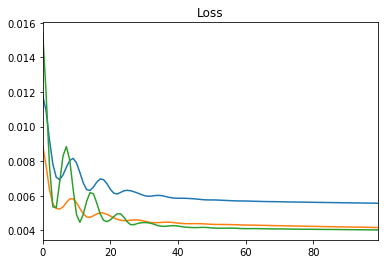

In [14]:
input_buffer = []
output_buffer = []
#anomaly_batches = [0,2,3,18]
anomaly_batches = [0,4,5,7,26,38]
count = -1 # jump the anomaly batches, not used for retraining
loss_overall = []
err_max_0 = 0
for data in test_set_list:
    count +=1
    (input_n, output_n) = sess.run([input_, output_], {p_input: data, p_is_training: False})
    input_buffer.append(input_n)
    output_buffer.append(output_n)
    if count in anomaly_batches: 
        continue    
    
    if count == 1:
        err_max_0 = max(abs(input_n- output_n).ravel())
        
    # retrain 
    error_max = max(abs(input_n-output_n).ravel())
    if error_max >= err_max_0:
        print("Retrain at batch number %d\n"%count)
        loss = []
        for i in range(100):
            (loss_val, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
            loss.append(loss_val)
            print('Retrain-iter %d:' % (i + 1), loss_val)
        loss_overall.append(loss_val)
        pd.Series(loss).plot(title="Loss")

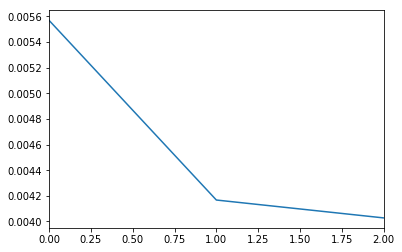

In [15]:
pd.Series(loss_overall).plot()

In [16]:
foo = pd.Series(np.array(input_buffer).ravel())
bar = pd.Series(np.array(output_buffer).ravel())
foobar = pd.concat((foo,bar),axis=1)

foobar.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv",header=['input','output'],index=None)

Normal: Max 0.35, min 0.00, avg 0.07, median 0.05
Abnormal: Max 0.56, min 0.00, avg 0.13, median 0.08


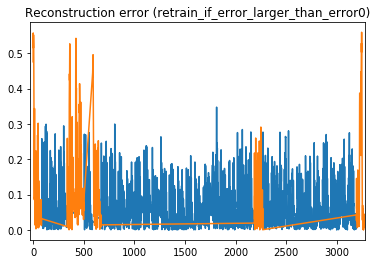

In [17]:
# reconstruction error of normal data(retrain after each batch)

normal =pd.DataFrame( foobar[label[1008:]== 'normal'])
abnormal =pd.DataFrame( foobar[label[1008:]== 'anomaly'])

error1 = abs( normal[0]- normal[1])
error2 = abs( abnormal[0]- abnormal[1])
error1.plot()
error2.plot()
plt.xlim(-30,error1.size+error2.size)
plt.title("Reconstruction error (retrain_if_error_larger_than_error0)")
print("Normal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error1),min(error1), np.mean(error1),np.median(error1)))
print("Abnormal: Max %.2f, min %.2f, avg %.2f, median %.2f"%(max(error2),min(error2), np.mean(error2),np.median(error2)))

In [18]:
# statistical results in batch
normal_batches = [error1[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error1.size//(batch_num*step_num))]
abnormal_batches = [error2[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error2.size//(batch_num*step_num))]

batch_error1  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in normal_batches])
batch_error2  = pd.DataFrame([[max(y),min(y),np.mean(y),np.median(y)] for y in abnormal_batches])

batch_error1.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/normal_retraining(batch).csv",header=['max','min','avg','median'],index=None)
batch_error2.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/abnormal_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [23]:
error0 =  abs( foobar[0]- foobar[1])
all_batches = [error0[i*(batch_num*step_num):(i+1)*(batch_num*step_num)]for i in range(error0.size//(batch_num*step_num))]
batch_error0  = pd.DataFrame([[max(x),min(x),np.mean(x),np.median(x)] for x in all_batches])
batch_error0.to_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/all_retraining(batch).csv",header=['max','min','avg','median'],index=None)


In [21]:
data = pd.read_csv("C:/Users/Bin/Desktop/Thesis/Synthetic example (Power demand dataset)/retrain_p1/retraining_if_error_larger_than_error0.csv")

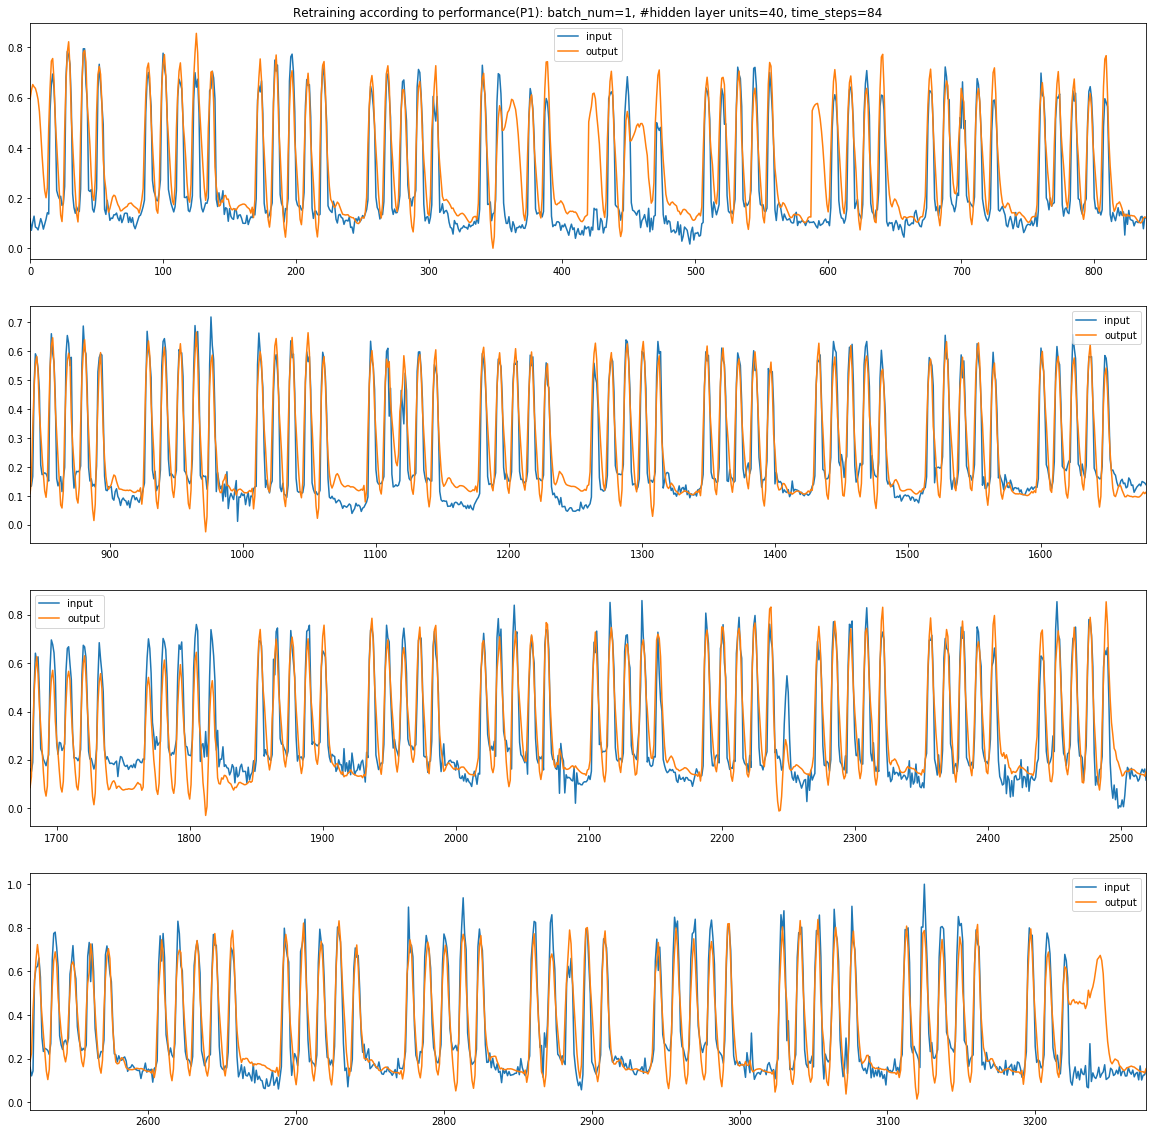

In [22]:
fig, axes = plt.subplots(nrows=4, ncols=1,figsize=(20,20))
axes[0].set_title("Retraining according to performance(P1): batch_num=1, #hidden layer units=40, time_steps=84")
data[:840].plot(ax=axes[0])
data[840*1:840*2].plot(ax=axes[1])
data[840*2:840*3].plot(ax=axes[2])
data[840*3:].plot(ax=axes[3])
